In [2]:
# Check GPU device.
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
# Specify GPU to use. 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

## Read and compile tranining and validation dataset.

In [4]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])

In [4]:
# df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc'] # Using raw.
df_train['input_text']=df_train['mission_spellchk']+df_train['prgrm_dsc_spellchk'] # Using spell-checked.
df_train['NTEE_M']=df_train['NTEE1'].apply(ntee2major)

len(df_train['input_text']), len(df_train['NTEE1'].drop_duplicates()), len(df_train['NTEE_M'].drop_duplicates())

(229472, 25)

In [8]:
# Build training and testing data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    sampleDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(120000)
    trainDF, valDF =train_test_split(sampleDF, test_size=.3)
    small_num=trainDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

In [9]:
# See the composition by NTEE major groups.
print(trainDF.groupby('NTEE1').count()['EIN']/len(trainDF), '\n'*2, valDF.groupby('NTEE1').count()['EIN']/len(valDF))

NTEE1
A    0.112142
B    0.166717
C    0.022450
D    0.027600
E    0.063658
F    0.015350
G    0.034408
H    0.003142
I    0.018700
J    0.029150
K    0.013042
L    0.038308
M    0.028850
N    0.097517
O    0.011075
P    0.062925
Q    0.013383
R    0.006842
S    0.091275
T    0.014142
U    0.005908
V    0.002350
W    0.053800
X    0.028833
Y    0.038433
Name: EIN, dtype: float64 

 NTEE1
A    0.111483
B    0.167417
C    0.022667
D    0.028358
E    0.063708
F    0.014975
G    0.034292
H    0.003242
I    0.019050
J    0.029083
K    0.012717
L    0.038433
M    0.029325
N    0.097417
O    0.010875
P    0.063567
Q    0.013225
R    0.006967
S    0.090208
T    0.013867
U    0.006000
V    0.002342
W    0.053867
X    0.028325
Y    0.038592
Name: EIN, dtype: float64


### Prepare labels.

In [13]:
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=trainDF['NTEE1'], class_list=list(trainDF['NTEE1'].unique()))
y_val=one_hot(label_list=valDF['NTEE1'], class_list=list(trainDF['NTEE1'].unique()))

### Prepare input text.

In [15]:
stop_list=stopwords.words('english')+list(string.punctuation)
def tokenize_stopwords_remove(string):
    global stop_list
    return [s for s in nltk.word_tokenize(string) if s not in stop_list]

In [16]:
text_token_list_train=trainDF['input_text'].apply(tokenize_stopwords_remove)
text_token_list_val=valDF['input_text'].apply(tokenize_stopwords_remove)

**Moved to preprocessing pipeline.**
```Python
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list_train=p.map(spellcheck, text_token_list_train)
text_token_list_val=p.map(spellcheck, text_token_list_val)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map
```

In [17]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_token_list_train.to_list()+text_token_list_val.to_list())
print(list(tokenizer.word_index.items())[0:5])

[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('in', 5)]


In [18]:
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_val=tokenizer.texts_to_sequences(text_token_list_val)

In [19]:
# Pads sequences to the same length.
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )
x_val=pad_sequences(sequences=seq_encoding_text_val,
                    maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                     )

In [ ]:
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
# Note that in the embedding matrix above, each row corresponds to a word and each column corresponds to a dimension (axis). 
# Typically, we store this in a dense fashion, where we have a list of words and row ID’s which map to the corresponding row of the matrix. 
# For the above example, we’d have the following list in addition to the matrix:
# { hello: 0, there: 1, texas: 2, world: 3, … }

## Classifier.

### Not using pre-trained embedding.

In [149]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index), # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=32, # Size of the vector space in which words will be embedded.
                           )

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(max([len(s) for s in seq_encoding_text_train]),), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=len(y_train[0]), activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

In [150]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

In [ ]:
# fit the model
# Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
history=model.fit(x_train, y_train, validation_split=0.3, epochs=25, verbose=1)

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=1)
print('Accuracy: %f' % (accuracy*100))

### Use pre-trained GloVe embedding.

In [20]:
import gensim.downloader as api
EMBEDDING_DIM=100
glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))

In [21]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))

In [22]:
for word, index in tqdm(tokenizer.word_index.items()):
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

100%|██████████| 251685/251685 [00:00<00:00, 372840.88it/s]


In [23]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False
                           )

In [24]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)
f1 = as_keras_metric(tf.contrib.metrics.f1_score)

In [ ]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU, PReLU

# define the model
model = Sequential()
model.add(embedding_layer)
# model.add(Flatten())
model.add(Conv1D(128, 5, activation='softplus'))
model.add(GlobalMaxPool1D())
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dense(units=16, activation='softplus'))
# model.add(PReLU()) # https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7
model.add(Dense(units=16, activation='tanh'))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=len(y_train[0]), activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
#                                                                      precision, recall
                                                                    ])
# summarize the model
print(model.summary())

# fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=20, verbose=1)

'''
(10, sigmoid; 9, relu): loss: 0.4414 - acc: 0.8896 - precision: 0.1604 - recall: 0.8439 - val_loss: 0.3964 - val_acc: 0.8943 - val_precision: 0.1632 - val_recall: 0.8974
(10, softmax; 9, relu): loss: 0.5685 - acc: 0.8888 - precision: 0.1371 - recall: 0.8051 - val_loss: 0.5532 - val_acc: 0.8895 - val_precision: 0.1394 - val_recall: 0.8151
(10, relu;    9, relu): loss: 0.5377 - acc: 0.8838 - precision: 0.1646 - recall: 0.8411 - val_loss: 0.4271 - val_acc: 0.8903 - val_precision: 0.1558 - val_recall: 0.8884
(10, relu; 9, softmax): loss: 0.2596 - acc: 0.9037 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2303 - val_acc: 0.9135 - val_precision: 0.1111 - val_recall: 1.0000
(10, relu; 9, sigmoid): loss: 0.2681 - acc: 0.8975 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2272 - val_acc: 0.9121 - val_precision: 0.1111 - val_recall: 1.0000
(10, tanh; 9, sigmoid): loss: 0.2959 - acc: 0.8940 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2572 - val_acc: 0.9066 - val_precision: 0.1111 - val_recall: 1.0000
(10, relu;    9, tanh): loss: 0.4241 - acc: 0.8599 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.3609 - val_acc: 0.8885 - val_precision: 0.1111 - val_recall: 1.0000

(32, relu; 16, tanh; 9, sigmoid): loss: 0.2590 - acc: 0.9034 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2186 - val_acc: 0.9180 - val_precision: 0.1111 - val_recall: 1.0000
(32, relu; 16, tanh; 9,    relu): loss: 0.5613 - acc: 0.8654 - precision: 0.1360 - recall: 0.7180 - val_loss: 0.3850 - val_acc: 0.8889 - val_precision: 0.1394 - val_recall: 0.8721
(32, relu; 16, relu; 9,    relu): loss: 0.3902 - acc: 0.8876 - precision: 0.1396 - recall: 0.9328 - val_loss: 0.3618 - val_acc: 0.8889 - val_precision: 0.1377 - val_recall: 0.9532
(32, softmax; 16, relu; 9, relu): loss: 0.6418 - acc: 0.8916 - precision: 0.1212 - recall: 0.7585 - val_loss: 0.6097 - val_acc: 0.8942 - val_precision: 0.1276 - val_recall: 0.7584
(32, sigmoid; 16, relu; 9, relu): loss: 0.5048 - acc: 0.8885 - precision: 0.1421 - recall: 0.7762 - val_loss: 0.3169 - val_acc: 0.8889 - val_precision: 0.1363 - val_recall: 0.8788

(32, sigmoid; 32, sigmoid; 16, relu; 16, relu; 9, relu): loss: 0.3325 - acc: 0.8879 - precision: 0.1251 - recall: 0.9766 - val_loss: 0.4644 - val_acc: 0.7910 - val_precision: 0.1257 - val_recall: 0.9785
(32, softmax; 32, softmax; 16, relu; 16, relu; 9, relu): loss: 1.1298 - acc: 0.8889 - precision: 0.0933 - recall: 0.4219 - val_loss: 1.1113 - val_acc: 0.8889 - val_precision: 0.0952 - val_recall: 0.4569

1. Don't use sigmoid/softmax/tanh for output layer.
2. Using relu near output layer increases loss but improve precision.
3. sigmoid/tanh/softmax decreases loss, but also decreases precision.
4. Possible strategy: use softmax near input layer, use relu near output layer.
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32070, 100)        25168600  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32066, 128)        64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
__________

## Check results.

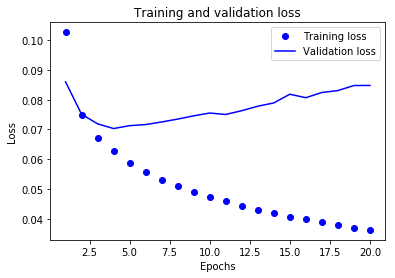

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

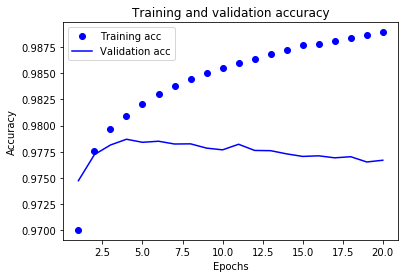

In [40]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

120000/120000 [==============================] - 126s 1ms/step


0.7410416666666667

In [47]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

60000/60000 [==============================] - 67s 1ms/step


0.772

In [42]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.9346993456194288 0.4851916666666667


In [25]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.8247847099301924 0.8380166666666666


In [45]:
df_val.sample(10)

,pred,true,prob
97857,4,5,0.491921
48309,10,16,0.445013
91307,13,13,0.998451
49997,23,0,0.392497
4109,11,11,0.858107
6911,23,16,0.429928
101330,23,23,0.833755
21658,22,8,0.821795
35628,13,18,0.344335
9273,9,12,0.315280


In [46]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     13088.0  0.908388  0.177154  0.142027  0.939100  0.990128  0.995451   
1     18944.0  0.906150  0.169570  0.109747  0.923321  0.984253  0.993402   
2      3171.0  0.813541  0.216008  0.148135  0.674415  0.921770  0.982658   
3      3552.0  0.906009  0.165231  0.144918  0.925063  0.983874  0.991304   
4      7536.0  0.871013  0.191857  0.155154  0.815629  0.978425  0.995479   
5      2036.0  0.629566  0.210578  0.134771  0.461040  0.634257  0.816017   
6      5651.0  0.699703  0.224970  0.136998  0.523264  0.768967  0.898311   
7       106.0  0.448607  0.104133  0.203171  0.380574  0.458627  0.506585   
8      2401.0  0.645444  0.224147  0.128084  0.463254  0.682072  0.849529   
9      3222.0  0.789126  0.219737  0.145655  0.659721  0.900570  0.960045   
10     1939.0  0.728381  0.222038  0.149119  0.541646  0.781846  0.934978   
11     4135.0  0.790978  0.196248  0.162105  0.668983  0.868191  0.950709   
12     3557.0  0.900789  0.181403  0.146918  0.924903  0.988990  0.995205   
13    11227.0  0.923705  0.155608  0.121359  0.952169  0.992989  0.996704   
14     1098.0  0.619019  0.235930  0.151741  0.414210  0.637582  0.841121   
15     6912.0  0.667097  0.221585  0.126351  0.483805  0.693039  0.869978   
16     1593.0  0.472803  0.190746  0.126787  0.315705  0.438267  0.619603   
17      580.0  0.415268  0.151513  0.118035  0.300510  0.392174  0.518703   
18    11235.0  0.809223  0.232173  0.145952  0.659935  0.938022  0.990062   
19      944.0  0.463488  0.184629  0.132051  0.315304  0.434593  0.594496   
20      165.0  0.345842  0.100687  0.150297  0.276739  0.344555  0.402169   
22     7654.0  0.842533  0.233198  0.135629  0.744700  0.983917  0.995033   
23     4672.0  0.700134  0.241582  0.148612  0.486153  0.778218  0.924833   
24     4582.0  0.821450  0.203442  0.148625  0.718156  0.917286  0.977041   

                
           max  
pred            
0     0.997781  
1     0.997820  
2     0.997292  
3     0.996258  
4     0.998737  
5     0.970404  
6     0.977922  
7     0.690596  
8     0.966446  
9     0.980046  
10    0.986202  
11    0.991070  
12    0.998159  
13    0.998610  
14    0.979060  
15    0.988523  
16    0.911286  
17    0.832576  
18    0.996336  
19    0.901521  
20    0.657184  
22    0.997171  
23    0.977141  
24    0.995323

In [35]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     12602.0  0.848058  0.192906  0.099420  0.793265  0.942826  0.977441   
1     26000.0  0.809861  0.238692  0.087219  0.683788  0.946383  0.980377   
2      2297.0  0.605833  0.191890  0.094463  0.444121  0.639296  0.778246   
3      3366.0  0.874512  0.173787  0.157057  0.883541  0.956173  0.967872   
4      6441.0  0.741391  0.234529  0.126705  0.554008  0.835144  0.945148   
5      1366.0  0.386526  0.105981  0.138421  0.305284  0.385955  0.467187   
6      4108.0  0.498052  0.147095  0.093204  0.387617  0.518314  0.620197   
8      2320.0  0.352670  0.128075  0.114436  0.243909  0.338815  0.453435   
9      4780.0  0.656115  0.247266  0.120240  0.423637  0.723281  0.890782   
10     1540.0  0.504510  0.168473  0.120028  0.371044  0.496594  0.645774   
11     4314.0  0.715330  0.189366  0.112852  0.583356  0.787513  0.871542   
12     3242.0  0.877686  0.178106  0.129092  0.897202  0.958898  0.972096   
13    11921.0  0.839911  0.196575  0.118600  0.780404  0.941785  0.971170   
14     1574.0  0.418690  0.133496  0.140829  0.314354  0.406837  0.524091   
15    10648.0  0.547153  0.193563  0.109558  0.393835  0.548929  0.714959   
16      418.0  0.222347  0.045120  0.103251  0.193242  0.220646  0.252260   
17        1.0  0.130555       NaN  0.130555  0.130555  0.130555  0.130555   
18     9300.0  0.676713  0.271094  0.113672  0.425342  0.741195  0.942738   
19       87.0  0.169295  0.028792  0.112522  0.147757  0.165717  0.188771   
22     5613.0  0.813688  0.217035  0.120058  0.738421  0.924710  0.964420   
23     4228.0  0.618473  0.193106  0.099853  0.471122  0.656026  0.788790   
24     3834.0  0.724429  0.196630  0.097521  0.595665  0.792248  0.883907   

                
           max  
pred            
0     0.995070  
1     0.993897  
2     0.894880  
3     0.974627  
4     0.982064  
5     0.617621  
6     0.768572  
8     0.642961  
9     0.956166  
10    0.853527  
11    0.940572  
12    0.981479  
13    0.987029  
14    0.754473  
15    0.908429  
16    0.344682  
17    0.130555  
18    0.991517  
19    0.247617  
22    0.985283  
23    0.900154  
24    0.959967

## Draft.

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

In [34]:
len(df_val[df_val.pred==df_val.true])

37694

In [38]:
df_95.pred.unique()

array([1, 0, 7, 5, 3, 4, 2])